# Scientific Programming - Project Work 

## Table of Contents
* [1. Libraries and Settings](#1-bullet)
* [2. Data collection](#2-bullet)
* [3. Data preprocessing](#3-bullet)
* [4. EDA (data overview, feature distribution, correlation analysis, geospatial analysis)](#4-bullet)
* [5. Data visualization (scatter plots, heat maps, bar chart)](#5-bullet)
* [6. Data insights](#6-bullet)
* [7. Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)](#12-bullet)

## 1. Libraries and Settings <a class="anchor" id="1-bullet"></a>

In [99]:
# Required
# !pip install nltk
# !pip install bs4
# !pip install seaborn
# !pip install scipy.stats
# !pip install openpyxl

# Libraries
import os
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import scipy.stats as stats
import random
import fnmatch
import openpyxl
import string
import requests
import csv
from sklearn import linear_model
import io
import folium

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Settings for seaborn
sns.set_theme(style="ticks", palette="pastel")

# Set seed
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Current working directory
print('Current working directory:', os.getcwd())

Current working directory: /Users/yireneyong/Desktop/Scientific_Programming/sp-project-work/sp-project-work


## 2. Data collection <a class="anchor" id="2-bullet"></a>

### Asteroids - NASA

In [100]:
# Connect to NASA API

import requests
import pandas as pd

# Set the API endpoint URL
url = "https://api.nasa.gov/neo/rest/v1/feed"

# Set the parameters for the API request
api_key = "96ycipvaBH52byeolyOAQPaaoEJCmLGZpzmWVwLG"
start_date = "2022-04-22"
end_date = "2022-04-26"

# Build the API request URL
request_url = f"{url}?start_date={start_date}&end_date={end_date}&api_key={api_key}"

# Send the API request and get the response
response = requests.get(request_url)

# Convert the response to JSON format
json_data = response.json()

# Extract the asteroid data from the JSON response
asteroid_data = []
for date in json_data["near_earth_objects"]:
    for asteroid in json_data["near_earth_objects"][date]:
        asteroid_data.append({
            "name": asteroid["name"],
            "diameter": asteroid["estimated_diameter"]["meters"]["estimated_diameter_max"],
            "velocity": asteroid["close_approach_data"][0]["relative_velocity"]["kilometers_per_second"],
            "distance": asteroid["close_approach_data"][0]["miss_distance"]["kilometers"]
        })

# Convert the asteroid data to a Pandas dataframe
asteroid_df = pd.DataFrame(asteroid_data)

# Display the dataframe
print(asteroid_df)

           name    diameter       velocity            distance
0   (2000 TU28)  366.471308  15.3356012156  41541586.745959377
1     (2003 HM)  259.441818  21.9748310242  65188931.401511058
2     (2006 FK)  326.617897  10.1083679975  34112182.467245229
3    (2009 CC3)  895.447192   9.5440172595  13949362.684353822
4   (2009 HX51)  363.111479   7.8830053039  72235507.834433399
..          ...         ...            ...                 ...
86    (2022 HQ)   21.579430   7.0407574106   3321172.032025893
87   (2022 HL1)   51.290860  12.8842563094   5320041.878895932
88   (2022 HE3)   51.290860   12.903674078   4702173.833326596
89    (2022 JT)   43.056624   4.6805394689   3247682.078388393
90   (2022 UW4)   59.984629  12.6366912766  37318257.084527753

[91 rows x 4 columns]


## 3. Data preprocessing <a class="anchor" id="3-bullet"></a>

### Data types

In [101]:
# what data types are in the dataframe?
asteroid_df.dtypes

name         object
diameter    float64
velocity     object
distance     object
dtype: object

### Count and identify missing values

In [102]:
# Count missing values
print(pd.isna(asteroid_df).sum())

# Identify rows with missing values
asteroid_df[asteroid_df.isna().any(axis=1)]

name        0
diameter    0
velocity    0
distance    0
dtype: int64


,name,diameter,velocity,distance


### Count and identify duplicated values 

In [103]:
# Count duplicated values
print(asteroid_df.duplicated().sum())

# Identify rows with duplicated values, e.g.:
asteroid_df[asteroid_df[['name', 'diameter', 'velocity', 'distance']].duplicated()]

0


,name,diameter,velocity,distance


In [104]:
# Convert the diameter, velocity, and distance columns to numeric data types
asteroid_df["diameter"] = pd.to_numeric(asteroid_df["diameter"])
asteroid_df["velocity"] = pd.to_numeric(asteroid_df["velocity"])
asteroid_df["distance"] = pd.to_numeric(asteroid_df["distance"])



In [105]:
# convert name to string
asteroid_df["name"] = asteroid_df["name"].astype(str)

In [106]:
# find the five closest asteroid to Earth
closest_asteroids = asteroid_df.sort_values("distance").head(5)

# display the five closest asteroids in the right order
print(closest_asteroids[["name", "distance"]].reset_index(drop=True))

         name      distance
0  (2022 HB1)  2.006649e+05
1  (2022 HB2)  8.317558e+05
2   (2022 HD)  1.417645e+06
3  (2022 HS1)  1.674893e+06
4  (2022 HK1)  1.677603e+06


In [107]:
# Set the API endpoint URL
url2 = "https://api.nasa.gov/neo/rest/v1/neo/browse/"

# Set the parameters for the API request
api_key = "96ycipvaBH52byeolyOAQPaaoEJCmLGZpzmWVwLG"

# Build the API request URL
request_url2 = f"{url2}?api_key={api_key}"

# Send the API request and get the response
response2 = requests.get(request_url2)

# Convert the response to JSON format
json_data2 = response2.json()

# Extract the asteroid data from the JSON response
asteroid_data2 = []

for asteroid in json_data2["near_earth_objects"]:
    asteroid_data2.append({
        "name": asteroid["name"],
        "diameter": asteroid["estimated_diameter"]["meters"]["estimated_diameter_max"],
        "velocity": asteroid["close_approach_data"][0]["relative_velocity"]["kilometers_per_second"],
        "distance": asteroid["close_approach_data"][0]["miss_distance"]["kilometers"],
        "is_sentry_object": asteroid["is_sentry_object"],
        "orbiting_body": asteroid["close_approach_data"][0]["orbiting_body"]
    })

# Convert the asteroid data to a Pandas dataframe
asteroid_df2 = pd.DataFrame(asteroid_data2)

# Display the dataframe
print(asteroid_df2)


                           name      diameter       velocity  \
0            433 Eros (A898 PA)  51527.607590   5.5786191875   
1          719 Albert (A911 TB)   4529.392731   3.4460290151   
2          887 Alinda (A918 AA)  10186.851583   6.8047854867   
3        1036 Ganymed (A924 UB)  85514.542927   6.3038665252   
4          1221 Amor (1932 EA1)   1986.277755  13.2693807828   
5         1566 Icarus (1949 MA)   2978.790628  27.0081177082   
6        1580 Betulia (1950 KA)   6855.513317  28.6869570374   
7     1620 Geographos (1951 RA)   5129.085974  11.7628248286   
8           1627 Ivar (1929 SH)  16750.970692   8.3835333947   
9           1685 Toro (1948 OA)   8166.575449   17.009119587   
10        1862 Apollo (1932 HA)   3564.839479  12.3118801079   
11      1863 Antinous (1948 EA)   4853.331752   18.079538445   
12      1864 Daedalus (1971 FA)   6607.542706  22.5061429999   
13      1865 Cerberus (1971 UA)   2594.418179  15.3277207205   
14      1866 Sisyphus (1972 XA)  19321.4

## Exploratory Data Analysis (EDA) <a class="anchor" id="4-bullet"></a>

### Univariate exploratory data analysis

### Summary statistics of numeric variables

In [108]:
asteroid_df.describe()

,diameter,velocity,distance
count,91.000000,91.000000,9.100000e+01
mean,179.586657,11.566233,3.686135e+07
std,223.963717,5.885565,2.332858e+07
min,9.419763,2.341220,2.006649e+05
25%,41.435503,6.904033,1.473444e+07
50%,95.069231,10.108368,3.543768e+07
75%,280.572165,14.753149,5.823982e+07
max,1486.072436,28.373382,7.233848e+07


### Statistical measures (min, max, std, mean, median, count) for selected variables

In [109]:
# diameter
print('Diameter:',
      'Count:', round(asteroid_df.diameter.count(), 1),
      'Min:', round(asteroid_df.diameter.min(), 1),
      'Max:', round(asteroid_df.diameter.max(), 1),
      'Mean:', round(asteroid_df.diameter.mean(), 1),
      'Median:', round(asteroid_df.diameter.median(), 1),
      'Std:', round(asteroid_df.diameter.std(), 1))

# velocity
print('Velocity:',
      'Count:', round(asteroid_df.velocity.count(), 1),
      'Min:', round(asteroid_df.velocity.min(), 1),
      'Max:', round(asteroid_df.velocity.max(), 1),
      'Mean:', round(asteroid_df.velocity.mean(), 1),
      'Median:', round(asteroid_df.velocity.median(), 1),
      'Std:', round(asteroid_df.velocity.std(), 1))

# distance
print('Distance:',
      'Count:', round(asteroid_df.distance.count(), 1),
      'Min:', round(asteroid_df.distance.min(), 1),
      'Max:', round(asteroid_df.distance.max(), 1),
      'Mean:', round(asteroid_df.distance.mean(), 1),
      'Median:', round(asteroid_df.distance.median(), 1),
      'Std:', round(asteroid_df.distance.std(), 1))

Diameter: Count: 91 Min: 9.4 Max: 1486.1 Mean: 179.6 Median: 95.1 Std: 224.0
Velocity: Count: 91 Min: 2.3 Max: 28.4 Mean: 11.6 Median: 10.1 Std: 5.9
Distance: Count: 91 Min: 200664.9 Max: 72338481.5 Mean: 36861353.9 Median: 35437681.0 Std: 23328584.4


### Boxplot

<Axes: xlabel='diameter'>

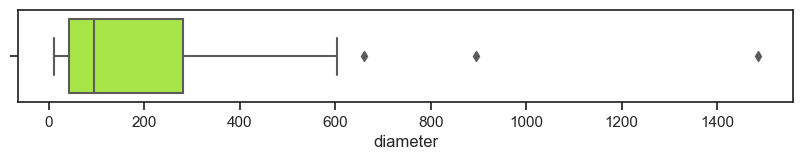

In [110]:
#Boxplot of all asteroids diameter
fig = plt.figure(figsize=(10,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=asteroid_df['diameter'], color="greenyellow")

### Histogram (matplotlib)

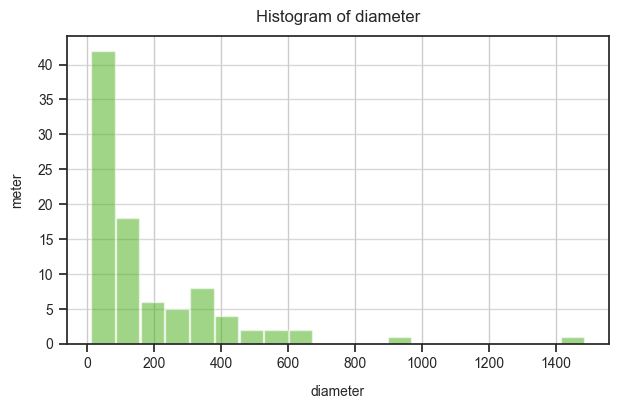

In [111]:
# Plot Histogram
fig = plt.figure( figsize=(7,4))
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
n, bins, patches = plt.hist(x=asteroid_df['diameter'], 
                            bins=20, 
                            color='#42AD12',
                            alpha=0.5, 
                            rwidth=0.95
                   )
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.grid(axis='y', alpha=0.75)

# Set labels
plt.xlabel('diameter', fontsize=10, labelpad=10)
plt.ylabel('meter', fontsize=10, labelpad=10)
plt.title('Histogram of diameter', fontsize=12, pad=10)

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

### Multivariate exploratory data analysis (EDA)

### Pivot tables

In [112]:
# Using pivot_table to reshape the data and calculate means 
pd.pivot_table(asteroid_df[['name', 'diameter', 'velocity', 'distance']],
               index=['name'],
               values=['diameter', 'velocity', 'distance'],
               aggfunc=np.mean)

,diameter,distance,velocity
name,,,
(2000 TU28),366.471308,4.154159e+07,15.335601
(2001 XP31),219.806221,5.078484e+07,6.864126
(2002 TA60),430.566244,6.705231e+07,23.339860
(2003 HM),259.441818,6.518893e+07,21.974831
(2003 YG136),51.765448,5.706390e+07,14.265074
...,...,...,...
162567 (2000 RW37),602.615057,6.929938e+07,5.818775
162679 (2000 TK1),1486.072436,7.123356e+07,28.195530
399308 (1993 GD),438.571068,5.490879e+07,9.946495


### Correlation matrix

In [113]:
corr = asteroid_df.corr()
corr

,diameter,velocity,distance
diameter,1.000000,0.346899,0.310366
velocity,0.346899,1.000000,0.442606
distance,0.310366,0.442606,1.000000


Looking at the correlation matrix, we can see that there is a positive correlation between diameter and velocity (r=0.3469). This suggests that as the diameter of the asteroid increases, its velocity also tends to increase. However, the correlation is not very strong.

There is also a positive correlation between velocity and distance (r=0.4426), which suggests that as the velocity of the asteroid increases, its distance from the Earth also tends to increase. Again, the correlation is not very strong.

Finally, there is a positive correlation between diameter and distance (r=0.3104). This suggests that as the diameter of the asteroid increases, its distance from the Earth also tends to increase. However, this correlation is weaker than the other two.

### Covariance matrix

In [114]:
cov = asteroid_df.cov()
cov

,diameter,velocity,distance
diameter,5.015975e+04,4.572666e+02,1.621588e+09
velocity,4.572666e+02,3.463988e+01,6.077063e+07
distance,1.621588e+09,6.077063e+07,5.442228e+14


Looking at the covariance matrix, we can see that the variance of diameter is much larger than the variance of velocity or distance, as expected. The covariance between diameter and velocity is positive, indicating that there is a tendency for larger asteroids to have higher velocities, but the covariance is relatively small, which suggests that the two variables are not strongly related. The covariance between diameter and distance is also positive but again, it is relatively small.

The covariance between velocity and distance is positive and relatively larger than the covariance between diameter and velocity, which indicates a stronger relationship between velocity and distance. However, it's difficult to compare the magnitudes of the covariances directly, especially when the variables have different units and scales.





### Compare the average velocity of the 5 smallest asteroid 

In [115]:
# find the five lightest asteroid 
size_asteroids = asteroid_df.sort_values("diameter").head(5)

# display the five closest asteroids in the right order
print(size_asteroids[["name", "diameter"]].reset_index(drop=True))

         name   diameter
0   (2020 UY)   9.419763
1  (2022 HK1)  12.191018
2  (2022 AP1)  12.474983
3   (2021 XZ)  13.553142
4  (2016 JQ5)  14.257388


In [116]:
# Create pivot table
table = pd.pivot_table(size_asteroids, 
                       values='velocity',
                       columns=['name'], 
                       aggfunc=np.mean)
print(table)

name      (2016 JQ5)  (2020 UY)  (2021 XZ)  (2022 AP1)  (2022 HK1)
velocity    15.52233  21.200504   9.519128     7.34545    5.689875


### ANOVA to compare the relationship between the sizes and velocity

In [122]:
# Create subsets (groups)
UY_2020 = size_asteroids.loc[size_asteroids['name'] == '2020 UY']
HK1_2022 = size_asteroids.loc[size_asteroids['name'] == '2022 HK1']
AP1_2022 = size_asteroids.loc[size_asteroids['name'] == '2022 AP1']

# Create ANOVA
fvalue, pvalue = stats.f_oneway(UY_2020['velocity'],
                                HK1_2022['velocity'], 
                                AP1_2022['velocity'])

# Print results
print('F-value:', fvalue, 'p-value', pvalue)


F-value: nan p-value nan


### Scatterplot-matrix

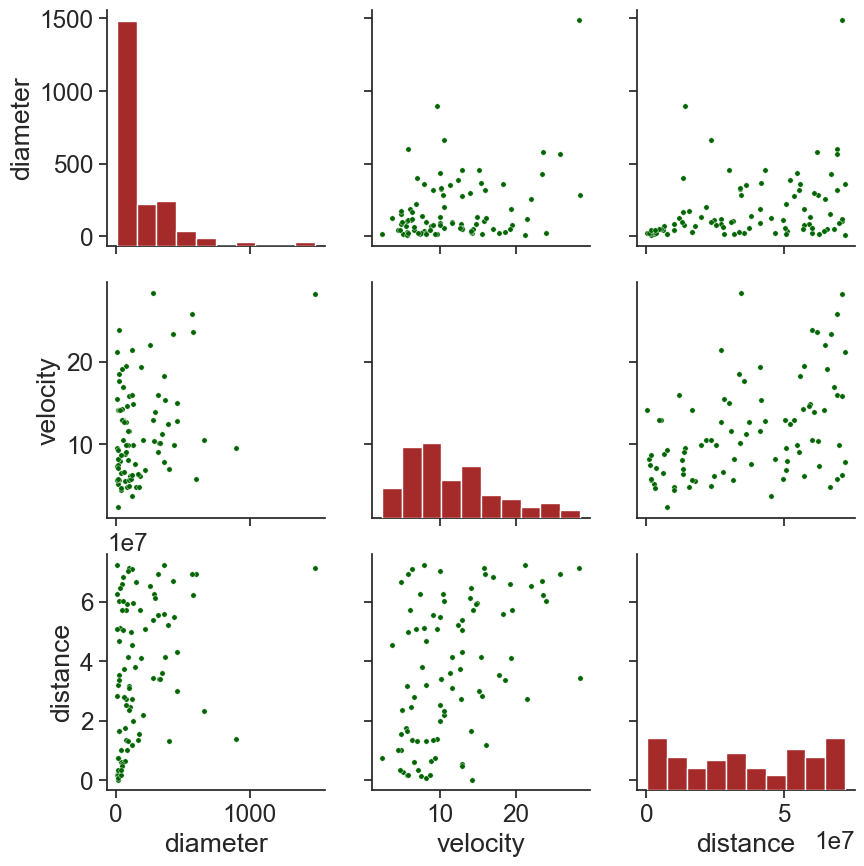

In [118]:
sns.set(style="ticks", font_scale=1.6)
g = sns.PairGrid(asteroid_df[['diameter',
                     'velocity',
                     'distance',
                     ]], 
                 height=3, 
                 aspect=1)
g.map_upper(sns.scatterplot,color='darkgreen', s=15)
g.map_lower(sns.scatterplot, color='darkgreen', s=15)
g.map_diag(plt.hist, color='brown')

### Scatterplot diameter vs velocity

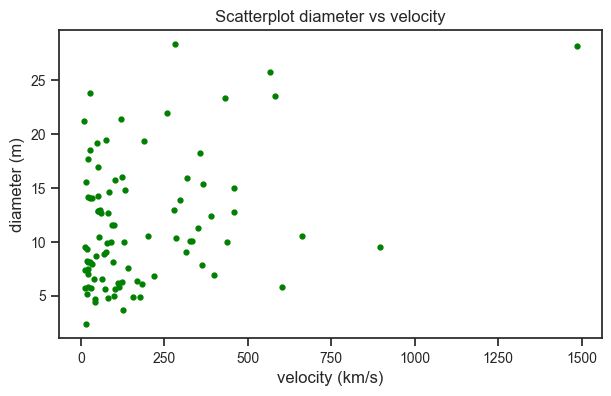

In [119]:
# Scatterplot
plt.figure(figsize=(7,4))
plt.plot(asteroid_df['diameter'], 
         asteroid_df['velocity'], 
         'o', 
         markersize=3.5,
         color="green")

# Add title and axes labels
plt.title('Scatterplot diameter vs velocity', fontsize=12)
plt.ylabel('diameter (m)', fontsize=12)
plt.xlabel('velocity (km/s)', fontsize=12)

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

### Pearson correlation diameter vs velocity

In [120]:
# Perform Persons correlation
res = stats.pearsonr(asteroid_df['velocity'], asteroid_df['diameter'])

# Print result
print(f'Pearsons correlation coefficient (r): {res[0]:.4f}')
print(f'p-value: {res[1]:.4f}')

Pearsons correlation coefficient (r): 0.3469
p-value: 0.0008


The correlation coefficient (r) of 0.3469 suggests a weak positive correlation between the two variables. It means that as one variable increases, the other variable tends to increase as well, but the relationship is not very strong.

In this case, the p-value is 0.0008, which is less than 0.05, indicating that the correlation is statistically significant and reject the null hypothesis that there is no correlation between the two variables, concluding that there is evidence of a correlation. This means that there is a low probability that the correlation coefficient of 0.3469 occurred by chance.

### Jupyter notebook --footer info--

In [121]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Darwin | 22.4.0
Datetime: 2023-05-09 16:22:00
Python Version: 3.10.9
-----------------------------------
